In [ ]:
import sys
from pathlib import Path

project_root = str(Path.cwd().parents[3])
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.cluster import HDBSCAN, KMeans
import time
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score,silhouette_score, confusion_matrix, ConfusionMatrixDisplay, f1_score,accuracy_score,classification_report
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.decomposition import PCA
from umap import UMAP
import optuna
import xgboost as xgb
import ast
from algorithms import *
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split



/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
centroid_tags = pd.read_parquet(os.path.join(Path.cwd().parent.parent.parent.parent,'data', "centroid-names.parquet"))
questions = pd.read_pickle(os.path.join(Path.cwd().parent.parent.parent.parent,'data','stackexchange_embeddings.pkl'))
original_data = pd.read_csv(os.path.join(Path.cwd().parent.parent.parent.parent,'data','stackexchange_dataset.csv'))

In [3]:
original_data.index = original_data.question_id
data = original_data.drop(columns=['question_id'])
data = original_data[~original_data.index.duplicated()]
data.loc[:,('tags')] = data.loc[:,('tags')].apply(ast.literal_eval)


In [4]:
exploded_series = centroid_tags['cluster_names'].explode()
tag_to_class_map = pd.Series(exploded_series.index, index=exploded_series.values).to_dict()
# tag_to_class_map

In [5]:
questions['tags'] = data.loc[data.index,'tags']
questions.head(2)

,title_embedding,question_text_embedding,tags
question_id,,,
79802517,"[0.008553513, -0.009437113, 0.009673767, -0.02...","[0.0013518566, -0.015674047, -0.004076924, -0....","[c#, entity-framework]"
79802934,"[0.019479005, 0.007850029, -0.020600174, -0.02...","[0.009473968, -0.014583107, -0.019139914, 0.00...",[ntp]


In [6]:
# questions

In [7]:
from collections import Counter

def get_best_centroid(tag_list, mapping_dict):
    if not isinstance(tag_list, list):
        return None
    # 1. Look up every tag in the list to see which centroid it belongs to
    #    Filters out tags that aren't in your top 100 centroids
    votes = [mapping_dict[tag] for tag in tag_list if tag in mapping_dict]
    
    if not votes:
        return None # No tags in this list matched any known centroid
    
    # 2. Majority Vote: Pick the centroid that appears most often in this row
    #    Example: ['python', 'pandas', 'numpy'] -> 3 votes for 'python-data'
    #    Example: ['c#', 'java'] -> Tie. The code below picks the first one encountered.
    most_common_centroid = Counter(votes).most_common(1)[0][0]
    
    return most_common_centroid

In [8]:
questions['target_class_name'] = questions['tags'].apply(
    lambda x: get_best_centroid(x, tag_to_class_map)
)

In [9]:
count = {}
for tag in questions.target_class_name:
    if tag in count:
        count[tag] += 1
    else:
        count[tag] = 1

In [10]:
threshold = 400
valid_classes = [tag  for tag,cnt in count.items() if cnt>= threshold]

In [11]:
questions_final = questions[questions['target_class_name'].isin(valid_classes)].copy()

In [12]:
questions_final.shape,questions.shape

((90432, 4), (99992, 4))

In [13]:
count2 = {}
for tag in questions_final.target_class_name:
    if tag in count2:
        count2[tag] += 1
    else:
        count2[tag] = 1

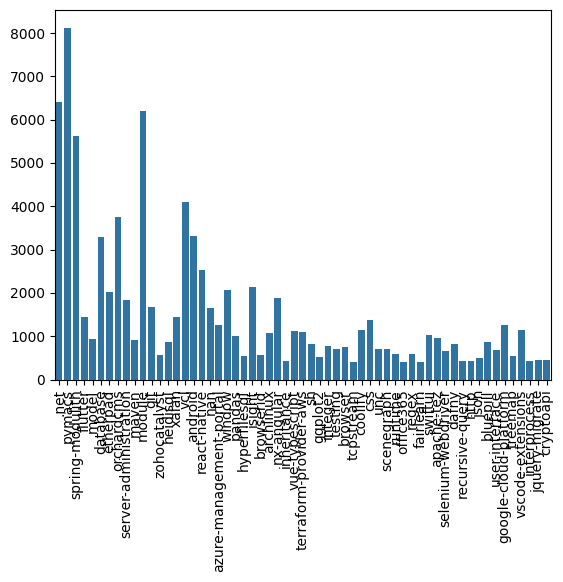

In [14]:
sns.barplot(x=list(count2.keys()), y=list(count2.values()))
plt.xticks(rotation=90)
plt.show()

In [ ]:
X = np.vstack(questions_final.question_text_embedding.to_numpy())    
y = LabelEncoder().fit_transform(questions_final['target_class_name'].to_numpy())


In [44]:
X.shape

(90432, 4096)

In [32]:
questions_final

,title_embedding,question_text_embedding,tags,target_class_name
question_id,,,,
79802517,"[0.008553513, -0.009437113, 0.009673767, -0.02...","[0.0013518566, -0.015674047, -0.004076924, -0....","[c#, entity-framework]",.net
79802909,"[-0.01977205, 0.0042978777, -0.03637585, -0.01...","[-0.0019663926, -0.024625326, -0.027527379, -0...","[python, pandas]",pymacs
79802931,"[-0.018374434, 0.006053594, -0.0047297603, -0....","[-0.029021142, 0.0017229741, -0.0093796635, -0...","[spring-boot, apache-kafka, spring-kafka, jvm-...",spring-modulith
79802907,"[0.027470868, -0.01224234, 0.003485559, -0.007...","[0.03642196, -0.014123824, -0.002404265, 0.005...","[flutter, dart]",flutter
79802892,"[0.007383958, 0.0040831426, -0.020424886, 0.00...","[0.028542964, 0.0022412355, -0.009976852, 0.00...","[java, apache-commons-collection]",spring-modulith
...,...,...,...,...
79662126,"[0.026081964, 0.0014296985, 0.010603848, -0.01...","[0.027758488, 0.014202704, 0.0013608634, 0.008...",[javascript],module
79662912,"[0.01792645, 0.011753886, 0.0029511105, -0.011...","[0.0017172531, 0.017311972, 0.016412362, -0.00...","[machine-learning, deep-learning, artificial-i...",model
79663172,"[0.014135985, -0.008573341, 0.006262712, -0.00...","[0.011241566, -0.004019965, -0.0010910758, -0....","[html, pdf]",etherpad


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

In [17]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss', 
    colsample_bytree=0.4, 
    colsample_bylevel=0.5,
    max_depth=4, 
    min_child_weight=3,
    reg_alpha=0.5,
    reg_lambda=1.5,
    tree_method='hist',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

In [18]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [19]:
model.fit(X_train, y_train,
          sample_weight=sample_weights,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-mlogloss:3.92316
[1]	validation_0-mlogloss:3.79784
[2]	validation_0-mlogloss:3.68305
[3]	validation_0-mlogloss:3.58501
[4]	validation_0-mlogloss:3.49731
[5]	validation_0-mlogloss:3.41565
[6]	validation_0-mlogloss:3.34273
[7]	validation_0-mlogloss:3.27805
[8]	validation_0-mlogloss:3.21506
[9]	validation_0-mlogloss:3.15611
[10]	validation_0-mlogloss:3.10145
[11]	validation_0-mlogloss:3.04949
[12]	validation_0-mlogloss:2.99900
[13]	validation_0-mlogloss:2.95247
[14]	validation_0-mlogloss:2.90827
[15]	validation_0-mlogloss:2.86626
[16]	validation_0-mlogloss:2.82585
[17]	validation_0-mlogloss:2.78669
[18]	validation_0-mlogloss:2.75065
[19]	validation_0-mlogloss:2.71467
[20]	validation_0-mlogloss:2.67959
[21]	validation_0-mlogloss:2.64685
[22]	validation_0-mlogloss:2.61588
[23]	validation_0-mlogloss:2.58465
[24]	validation_0-mlogloss:2.55557
[25]	validation_0-mlogloss:2.52779
[26]	validation_0-mlogloss:2.50045
[27]	validation_0-mlogloss:2.47416
[28]	validation_0-mlogloss:2.4

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.5
,colsample_bynode,None
,colsample_bytree,0.4
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [17]:
# model.save_model(os.path.join(Path.cwd().parent,'data','xgb_stack_balanced.json'))
model = xgb.XGBClassifier()
model.load_model(os.path.join(Path.cwd().parent,'data','xgb_stack_balanced.json'))

In [18]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [19]:
accuracy_score(y_test, y_pred)

0.6928123848138592

In [24]:
y_test.shape, y_pred.shape

((13565,), (13565,))

In [21]:
import plotly.graph_objects as go

In [22]:
def plot_interactive_confusion_matrix(cm, class_names=None):
    """
    Create an interactive confusion matrix using Plotly.
    
    Parameters:
    - cm: confusion matrix
    - class_names: list of class names (optional)
    """
    n_classes = cm.shape[0]
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    
    # Normalize by row (show percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero
    
    # Create hover text with both counts and percentages
    hover_text = []
    for i in range(n_classes):
        hover_row = []
        for j in range(n_classes):
            hover_row.append(
                f"True: {class_names[i]}<br>"
                f"Pred: {class_names[j]}<br>"
                f"Count: {cm[i, j]}<br>"
                f"Percentage: {cm_normalized[i, j]*100:.1f}%"
            )
        hover_text.append(hover_row)
    
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=cm_normalized,
        x=class_names,
        y=class_names,
        hovertext=hover_text,
        hoverinfo='text',
        colorscale='Blues',
        colorbar=dict(title="Percentage")
    ))
    
    fig.update_layout(
        title='Interactive Confusion Matrix (Normalized by Row)',
        xaxis_title='Predicted Class',
        yaxis_title='True Class',
        width=900,
        height=900,
        xaxis=dict(side='bottom'),
        yaxis=dict(autorange='reversed')
    )
    
    return fig

In [27]:
y_test.max(),y_train.max()

(np.int64(58), np.int64(58))

In [38]:
le = LabelEncoder()
le.fit(questions_final['target_class_name'].to_numpy())
y_test_original_names = le.inverse_transform(y_test)
y_pred_original_names = le.inverse_transform(y_pred)

cm = confusion_matrix(y_test,y_pred, labels=np.arange(len(le.classes_)))

In [36]:
le.classes_

array(['.net', 'android', 'apache-tez', 'archlinux',
       'azure-management-portal', 'bluepill', 'browser', 'browserid',
       'coolify', 'cryptoapi', 'css', 'dafny', 'database', 'etherpad',
       'fairlearn', 'flutter', 'ggplot2', 'git', 'google-cloud-platform',
       'heidisql', 'http', 'hyperfilesql', 'inheritance', 'integer',
       'interprocess', 'isight', 'jquery-migrate', 'json', 'maven',
       'model', 'module', 'nan', 'nx-angular', 'office365', 'orchardcms',
       'pandas', 'pymacs', 'react-native', 'recursive-query', 'regex',
       'runtime', 'scenegraph', 'selenium-webdriver',
       'server-administration', 'sh', 'spring-modulith', 'swiftui',
       'tcpstream', 'terraform-provider-aws', 'testing', 'treemap', 'unc',
       'user-interface', 'vcl', 'vscode-extensions', 'vue-typescript',
       'window', 'xalan', 'zohocatalyst'], dtype=object)

In [39]:
fig = plot_interactive_confusion_matrix(cm,le.classes_)
fig.show()

In [40]:
from sklearn.metrics import f1_score

In [43]:
f1_score(y_test, y_pred, average='weighted')

0.6882358640179885